In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

In [76]:
asf = pd.read_csv("https://raw.githubusercontent.com/Forever-D14/Corrupt_ML/main/CPI_dinero.csv", index_col=0)

##Funciones Implementadas para sacar información del dataset

In [77]:
def renom_estados(name):
  estados = {
    'Michoacán de Ocampo': 'Michoacán', 
    'México': 'Estado de México', 
    'Veracruz Ignacio de la Llave': 'Veracruz',
    'Coahuila de Zaragoza': 'Coahuila'}

  if name in estados:
    return estados[name]
  
  return name



def get_money(text):

  if pd.isna(text):    
    return np.nan
  re_dinero = re.compile(r'monto de ([\d|,|\.]+) pesos')
  res = re_dinero.search(text)
  if res:
    re_num = re.compile(r'[^0-9]')
    return float(re.sub(re_num, '', res.groups()[0][:-3]))
  return np.nan



###Importamos el dataset de ASF

In [78]:
ds_cpi = pd.read_csv('https://raw.githubusercontent.com/Erick-INCS/Corruption-analysis/main/datasets/CPI_Mex_full.csv')

ds_cpi['estado'] = ds_cpi['estado'].map(renom_estados)

ds_cpi.rename(columns = {'estado':'Entidad Federativa'},inplace=True)

ds_cpi

,Entidad Federativa,municipio,Accesibilidad al espacio público abierto,Acceso a Internet,Acceso a agua mejorada,Aglomeración económica,CALIDAD DE VIDA,Calidad del aire,Capacidad institucional y ﬁnanzas municipales,Coeﬁciente de Gini,Concentraciones de material particulado,Concentración de CO2,Crecimiento económico,Densidad de la interconexión vial,Densidad de médicos,Densidad económica,Densidad poblacional,Densidad vial,Desempleo juvenil,Deuda subnacional,EQUIDAD E INCLUSIÓN SOCIAL,Educación,Empleo,Energía,Equidad económica,Espacio habitable suﬁciente,Espacio público,Esperanza de vida al nacer,Eﬁciencia del gasto local,Eﬁciencia en el uso de suelo,Fatalidades de tránsito,Forma urbana,GOBERNANZA Y LEGISLACIÓN URBANA,Gobernanza de la urbanización,INFRAESTRUCTURA DE DESARROLLO,Inclusión de género,Inclusión social,Infraestructura de comunicaciones,Infraestructura de vivienda,Infraestructura social,Inscripción equitativa en educación a nivel secundario,Longitud de transporte masivo,Manejo de residuos,Movilidad urbana,Número de estaciones de monitoreo,PRODUCTIVIDAD,Participación electoral,Participación y rendición de cuentas,Producto urbano per cápita,Promedio de años de escolaridad,Proporción de generación de energía renovable,Recaudación de ingresos propios,Recolección de residuos sólidos,Relación de dependencia de la tercera edad,Relación empleo-población,SOSTENIBILIDAD AMBIENTAL,Salud,Seguridad y protección,Superﬁcie destinada a vías,Tasa de alfabetización,Tasa de desempleo,Tasa de homicidios,Tasa de mortalidad de menores de 5 años,Tasa de pobreza,Tratamiento de aguas residuales,Velocidad de banda ancha promedio,Vivienda durable,Viviendas en barrios precarios,Áreas verdes per cápita
0,Aguascalientes,Aguascalientes,73.28,27.92,99.02,68.10,69.72,62.83,43.60,49.45,67.43,46.08,51.88,100.00,71.24,68.10,42.90,84.57,62.88,14.66,72.49,85.15,64.44,0.0,47.80,100.0,63.96,73.16,91.34,0.00,84.71,89.49,29.10,0.00,64.85,90.33,79.34,35.68,85.48,71.24,90.33,0.0,41.47,42.36,75.0,61.48,43.70,43.70,41.23,73.79,0.0,24.80,2.94,62.54,58.77,34.77,67.44,62.34,83.91,96.51,70.12,62.34,61.71,46.15,80.00,43.44,99.99,95.80,54.65
1,Aguascalientes,Jesús María,38.22,32.03,97.96,70.14,60.84,56.75,20.87,53.62,67.42,46.08,59.68,100.00,21.70,70.14,10.60,78.63,74.44,3.62,73.72,71.44,69.28,0.0,51.67,100.0,38.48,74.97,43.66,100.00,81.19,80.49,56.84,100.00,52.60,85.28,84.21,43.06,77.14,21.70,85.28,0.0,83.20,40.59,NaN,66.37,49.65,49.65,48.97,47.14,0.0,15.33,99.36,70.39,57.34,69.97,73.82,59.62,62.82,95.74,81.23,59.62,72.67,49.71,67.03,54.10,100.00,93.98,38.73
2,Aguascalientes,San Francisco de los Romo,100.00,8.40,98.42,65.86,62.71,56.75,37.20,60.70,67.43,46.08,60.89,100.00,27.90,65.86,12.31,87.82,69.52,0.00,72.67,75.79,64.59,0.0,47.86,100.0,58.96,73.16,100.00,0.00,77.64,88.00,29.81,0.00,51.66,87.23,82.93,25.92,77.68,27.90,87.23,0.0,35.36,38.82,NaN,63.78,52.23,52.23,51.47,57.57,0.0,11.61,2.24,70.31,55.52,30.70,64.17,51.93,76.19,94.02,73.66,51.93,55.17,35.02,68.48,43.44,100.00,96.33,17.93
3,Baja California,Ensenada,28.97,45.03,85.26,57.58,54.24,64.29,44.57,45.63,82.50,46.08,42.72,100.00,50.46,57.58,16.13,74.58,78.69,57.96,72.79,72.25,63.01,0.0,44.34,100.0,27.56,69.20,61.59,46.85,93.74,81.22,42.42,46.85,56.56,92.33,81.71,49.57,54.68,50.46,92.33,0.0,89.10,46.87,NaN,54.44,35.83,35.83,27.83,49.14,0.0,14.15,91.14,57.61,51.18,76.70,67.96,49.20,69.07,95.35,74.85,49.20,66.72,43.04,87.07,54.10,17.34,84.74,26.14
4,Baja California,Mexicali,42.90,37.96,95.59,55.86,59.45,35.36,66.59,48.62,0.00,46.08,51.07,95.50,59.54,55.86,12.96,75.59,69.51,59.07,74.23,85.32,70.31,100.0,48.49,100.0,29.74,66.38,100.00,0.00,99.33,79.94,29.64,0.00,57.87,92.00,82.18,40.70,59.52,59.54,92.00,0.0,97.71,49.66,60.0,59.08,22.34,22.34,40.55,74.43,100.0,40.70,95.51,61.60,62.73,77.69,62.00,60.72,68.72,96.22,77.89,60.72,57.62,48.37,99.91,43.44,29.52,94.85,16.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

## Aplicar reduccion de la dimensionalidad

In [79]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
ds_cpi

,Entidad Federativa,municipio,Accesibilidad al espacio público abierto,Acceso a Internet,Acceso a agua mejorada,Aglomeración económica,CALIDAD DE VIDA,Calidad del aire,Capacidad institucional y ﬁnanzas municipales,Coeﬁciente de Gini,Concentraciones de material particulado,Concentración de CO2,Crecimiento económico,Densidad de la interconexión vial,Densidad de médicos,Densidad económica,Densidad poblacional,Densidad vial,Desempleo juvenil,Deuda subnacional,EQUIDAD E INCLUSIÓN SOCIAL,Educación,Empleo,Energía,Equidad económica,Espacio habitable suﬁciente,Espacio público,Esperanza de vida al nacer,Eﬁciencia del gasto local,Eﬁciencia en el uso de suelo,Fatalidades de tránsito,Forma urbana,GOBERNANZA Y LEGISLACIÓN URBANA,Gobernanza de la urbanización,INFRAESTRUCTURA DE DESARROLLO,Inclusión de género,Inclusión social,Infraestructura de comunicaciones,Infraestructura de vivienda,Infraestructura social,Inscripción equitativa en educación a nivel secundario,Longitud de transporte masivo,Manejo de residuos,Movilidad urbana,Número de estaciones de monitoreo,PRODUCTIVIDAD,Participación electoral,Participación y rendición de cuentas,Producto urbano per cápita,Promedio de años de escolaridad,Proporción de generación de energía renovable,Recaudación de ingresos propios,Recolección de residuos sólidos,Relación de dependencia de la tercera edad,Relación empleo-población,SOSTENIBILIDAD AMBIENTAL,Salud,Seguridad y protección,Superﬁcie destinada a vías,Tasa de alfabetización,Tasa de desempleo,Tasa de homicidios,Tasa de mortalidad de menores de 5 años,Tasa de pobreza,Tratamiento de aguas residuales,Velocidad de banda ancha promedio,Vivienda durable,Viviendas en barrios precarios,Áreas verdes per cápita
0,Aguascalientes,Aguascalientes,73.28,27.92,99.02,68.10,69.72,62.83,43.60,49.45,67.43,46.08,51.88,100.00,71.24,68.10,42.90,84.57,62.88,14.66,72.49,85.15,64.44,0.0,47.80,100.0,63.96,73.16,91.34,0.00,84.71,89.49,29.10,0.00,64.85,90.33,79.34,35.68,85.48,71.24,90.33,0.0,41.47,42.36,75.0,61.48,43.70,43.70,41.23,73.79,0.0,24.80,2.94,62.54,58.77,34.77,67.44,62.34,83.91,96.51,70.12,62.34,61.71,46.15,80.00,43.44,99.99,95.80,54.65
1,Aguascalientes,Jesús María,38.22,32.03,97.96,70.14,60.84,56.75,20.87,53.62,67.42,46.08,59.68,100.00,21.70,70.14,10.60,78.63,74.44,3.62,73.72,71.44,69.28,0.0,51.67,100.0,38.48,74.97,43.66,100.00,81.19,80.49,56.84,100.00,52.60,85.28,84.21,43.06,77.14,21.70,85.28,0.0,83.20,40.59,NaN,66.37,49.65,49.65,48.97,47.14,0.0,15.33,99.36,70.39,57.34,69.97,73.82,59.62,62.82,95.74,81.23,59.62,72.67,49.71,67.03,54.10,100.00,93.98,38.73
2,Aguascalientes,San Francisco de los Romo,100.00,8.40,98.42,65.86,62.71,56.75,37.20,60.70,67.43,46.08,60.89,100.00,27.90,65.86,12.31,87.82,69.52,0.00,72.67,75.79,64.59,0.0,47.86,100.0,58.96,73.16,100.00,0.00,77.64,88.00,29.81,0.00,51.66,87.23,82.93,25.92,77.68,27.90,87.23,0.0,35.36,38.82,NaN,63.78,52.23,52.23,51.47,57.57,0.0,11.61,2.24,70.31,55.52,30.70,64.17,51.93,76.19,94.02,73.66,51.93,55.17,35.02,68.48,43.44,100.00,96.33,17.93
3,Baja California,Ensenada,28.97,45.03,85.26,57.58,54.24,64.29,44.57,45.63,82.50,46.08,42.72,100.00,50.46,57.58,16.13,74.58,78.69,57.96,72.79,72.25,63.01,0.0,44.34,100.0,27.56,69.20,61.59,46.85,93.74,81.22,42.42,46.85,56.56,92.33,81.71,49.57,54.68,50.46,92.33,0.0,89.10,46.87,NaN,54.44,35.83,35.83,27.83,49.14,0.0,14.15,91.14,57.61,51.18,76.70,67.96,49.20,69.07,95.35,74.85,49.20,66.72,43.04,87.07,54.10,17.34,84.74,26.14
4,Baja California,Mexicali,42.90,37.96,95.59,55.86,59.45,35.36,66.59,48.62,0.00,46.08,51.07,95.50,59.54,55.86,12.96,75.59,69.51,59.07,74.23,85.32,70.31,100.0,48.49,100.0,29.74,66.38,100.00,0.00,99.33,79.94,29.64,0.00,57.87,92.00,82.18,40.70,59.52,59.54,92.00,0.0,97.71,49.66,60.0,59.08,22.34,22.34,40.55,74.43,100.0,40.70,95.51,61.60,62.73,77.69,62.00,60.72,68.72,96.22,77.89,60.72,57.62,48.37,99.91,43.44,29.52,94.85,16.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [80]:
ds_cpi_reduce = ds_cpi.groupby(['Entidad Federativa', 'municipio']).mean()
ds_cpi_reduce.head()

Accesibilidad al espacio público abierto  ...  Áreas verdes per cápita
Entidad Federativa municipio                                                            ...                         
Aguascalientes     Aguascalientes                                                73.28  ...                    54.65
                   Jesús María                                                   38.22  ...                    38.73
                   San Francisco de los Romo                                    100.00  ...                    17.93
Baja California    Ensenada                                                      28.97  ...                    26.14
                   Mexicali                                                      42.90  ...                    16.58

[5 rows x 67 columns]

Varianza acumulada explicada por mis dos nuevas variables: 32.37%


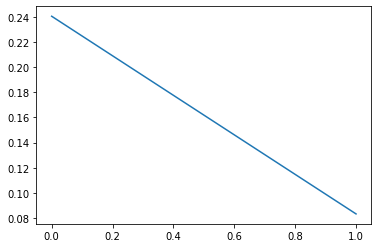

In [81]:
std_scaler =  StandardScaler()



pca = PCA(2)
ds_cpi_reduce = ds_cpi.groupby(['Entidad Federativa', 'municipio']).mean()

ds_cpi_reduce[ds_cpi_reduce.columns] = std_scaler.fit_transform(ds_cpi_reduce)


ds_cpi_reduce = ds_cpi_reduce.fillna(ds_cpi_reduce.mean())
pca.fit(ds_cpi_reduce)

plt.plot(
       range(len(pca.explained_variance_)),
       pca.explained_variance_ratio_
   )

print("Varianza acumulada explicada por mis dos nuevas variables: {:.2%}".format(np.sum(pca.explained_variance_ratio_)))


In [82]:
ds_cpi_reduced = pd.DataFrame(
    pca.transform(ds_cpi_reduce),
    index=ds_cpi_reduce.copy().index)

ds_cpi_reduced.head()

0         1
Entidad Federativa municipio                                    
Aguascalientes     Aguascalientes            -3.184971  0.033649
                   Jesús María               -1.246107 -1.580203
                   San Francisco de los Romo -1.282830  1.800385
Baja California    Ensenada                  -0.722191 -0.058037
                   Mexicali                  -4.293833  1.888747

### Clusterizacion

In [83]:
from sklearn.cluster import KMeans

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


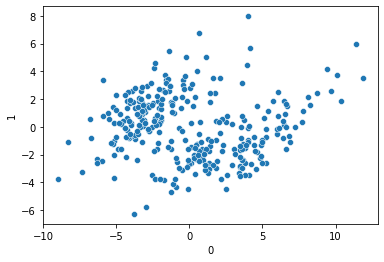

In [84]:
sns.scatterplot(ds_cpi_reduced[0], ds_cpi_reduced[1]);

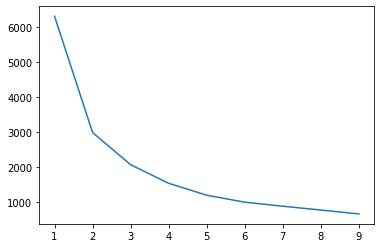

In [85]:
var = []

for i in range(1,10):
  kmeans = KMeans(n_clusters = i, init = "k-means++")
  kmeans.fit(ds_cpi_reduced)

  var.append(kmeans.inertia_)

plt.plot(range(1,10),var);

In [86]:
kmeans = KMeans(n_clusters = 2, init= "k-means++")
kmeans.fit(ds_cpi_reduced)
ds_cpi['cluster'] = kmeans.predict(ds_cpi_reduced)
ds_cpi_reduced['cluster'] = kmeans.predict(ds_cpi_reduced)

ds_cpi.head()

ds_cpi.to_csv("Hola.csv")

In [87]:
ds_cpi_cluster = ds_cpi.drop(columns=['Entidad Federativa', 'municipio'])\
                       .groupby('cluster').mean()

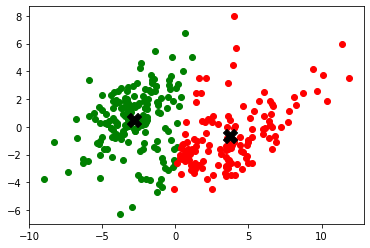

In [88]:
plt.scatter(ds_cpi_reduced[0][ds_cpi_reduced['cluster'] == 0], ds_cpi_reduced[1][ds_cpi_reduced['cluster']==0], color = "green")
plt.scatter(ds_cpi_reduced[0][ds_cpi_reduced['cluster'] == 1], ds_cpi_reduced[1][ds_cpi_reduced['cluster']==1], color = "red")
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color = "k",marker='X', s=200)

In [89]:
import seaborn as sns

In [90]:
ds_cpi_reduce

Accesibilidad al espacio público abierto  ...  Áreas verdes per cápita
Entidad Federativa municipio                                                            ...                         
Aguascalientes     Aguascalientes                                             0.512627  ...                 0.053087
                   Jesús María                                               -1.199382  ...                -0.345206
                   San Francisco de los Romo                                  1.817387  ...                -0.865588
Baja California    Ensenada                                                  -1.651067  ...                -0.660187
                   Mexicali                                                  -0.970854  ...                -0.899363
...                                                                                ...  ...                      ...
Yucatán            Progreso                                                  -0.972318  ...                 1.187670
                   Umán                                                       0.666932  ...                -0.714227
Zacatecas          Fresnillo                                                 -0.370723  ...                -0.885102
                   Guadalupe                                                  0.680117  ...                -1.082497
                   Zacatecas                                                 -0.273061  ...                -0.464043

[305 rows x 67 columns]

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

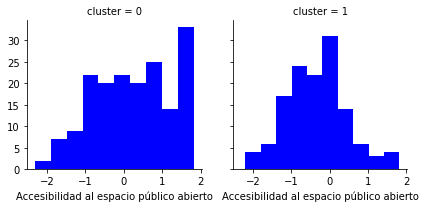

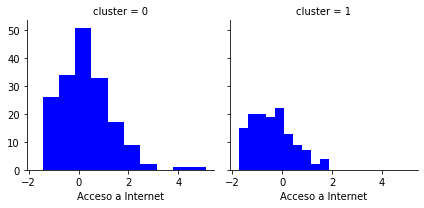

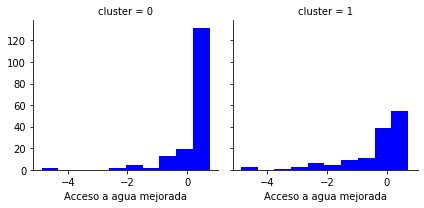

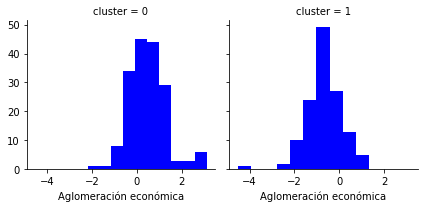

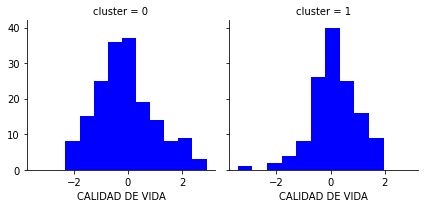

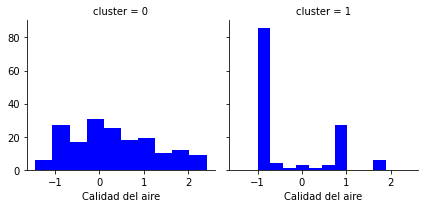

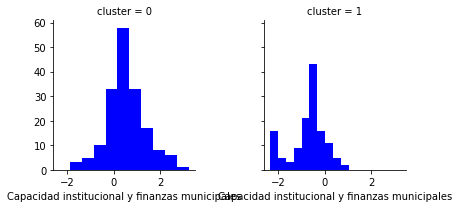

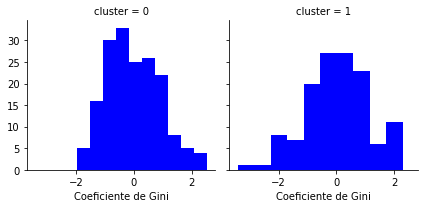

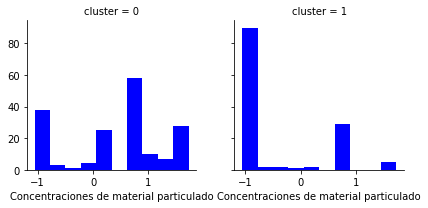

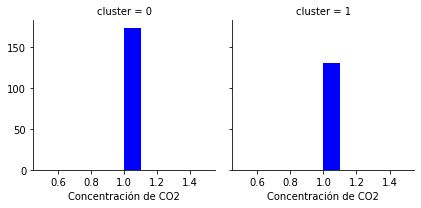

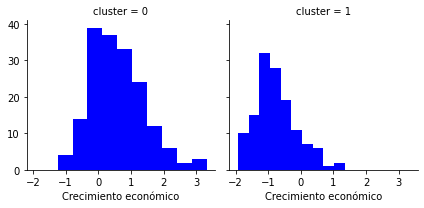

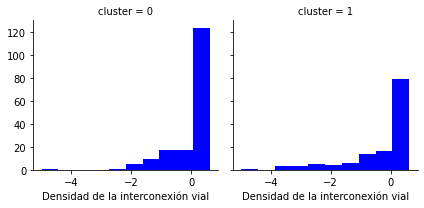

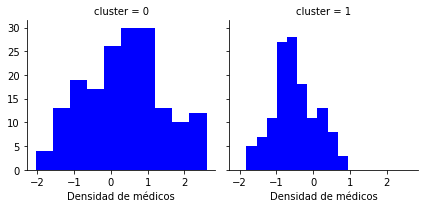

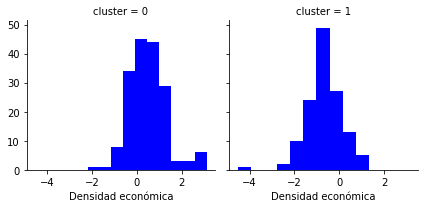

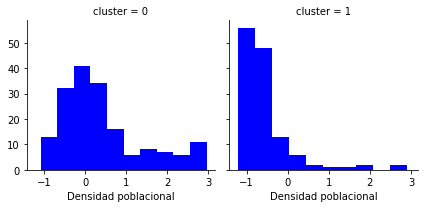

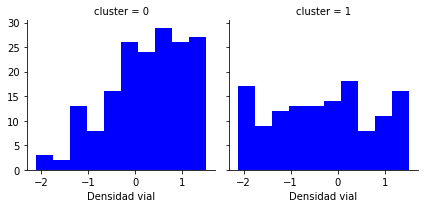

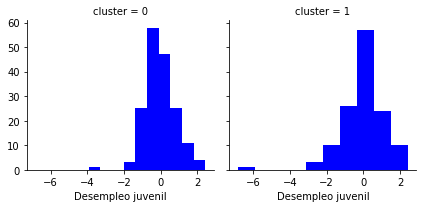

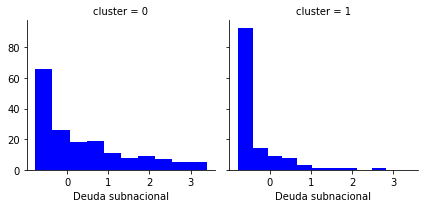

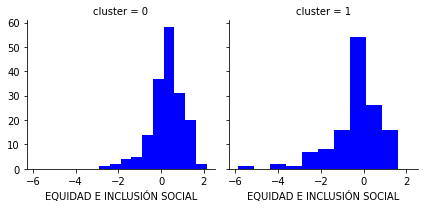

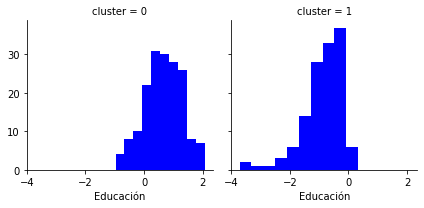

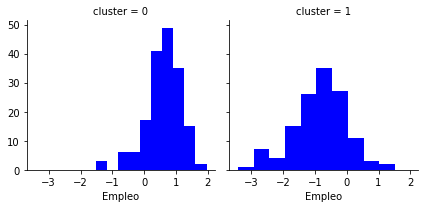

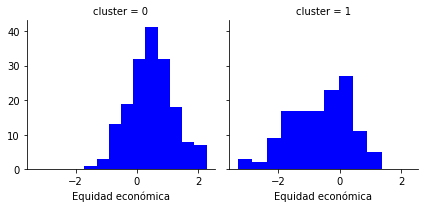

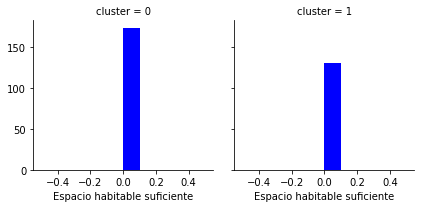

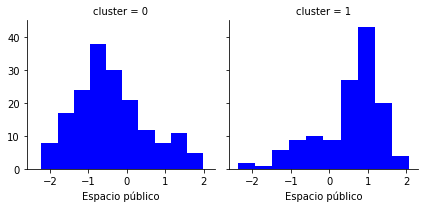

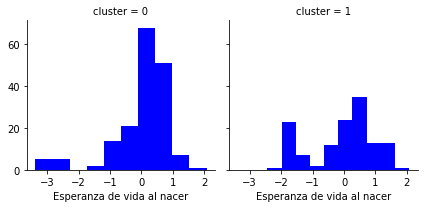

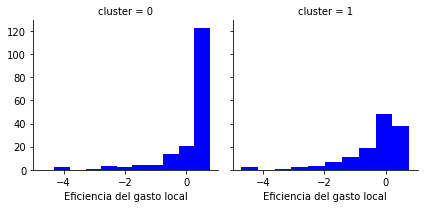

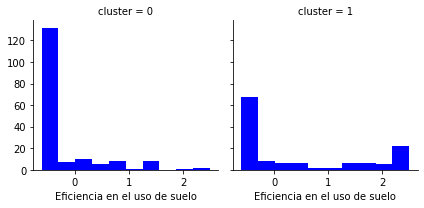

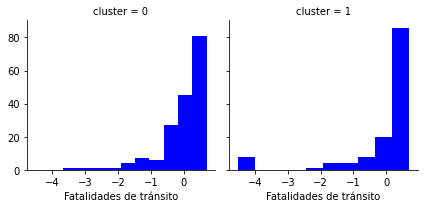

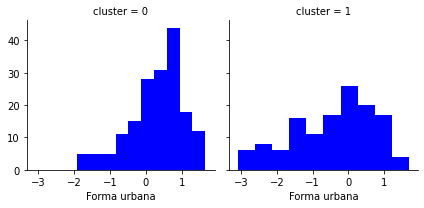

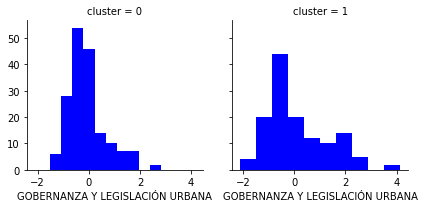

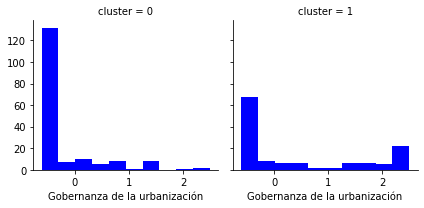

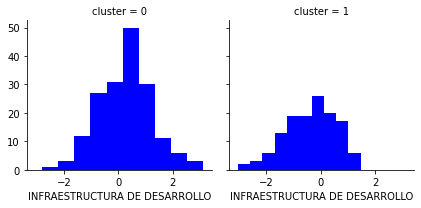

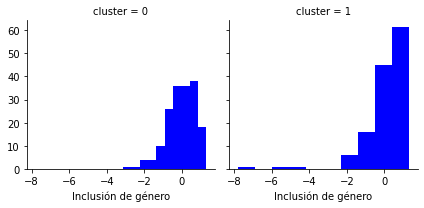

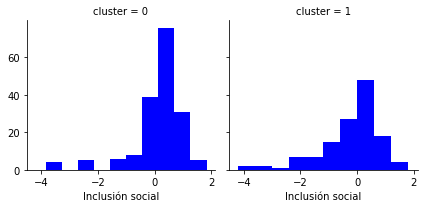

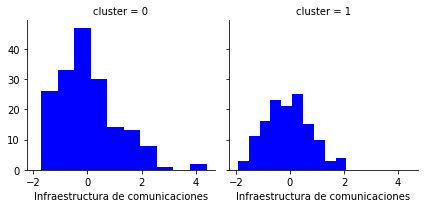

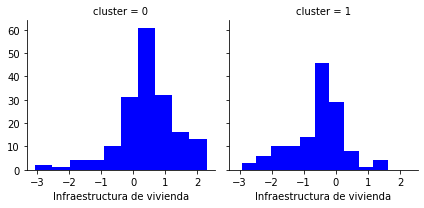

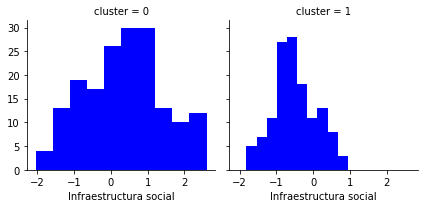

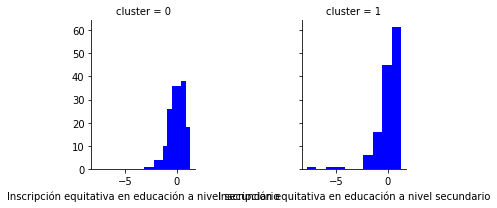

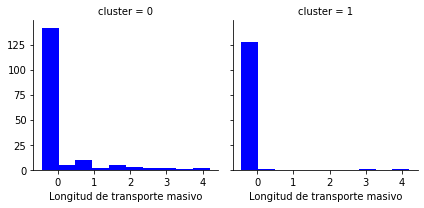

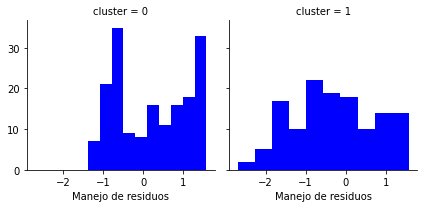

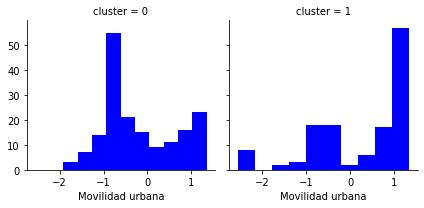

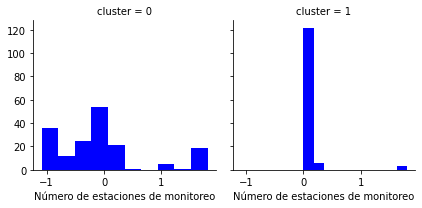

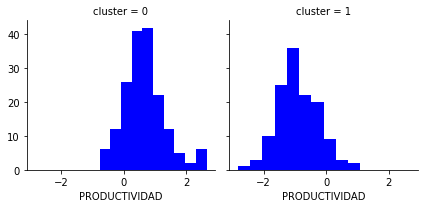

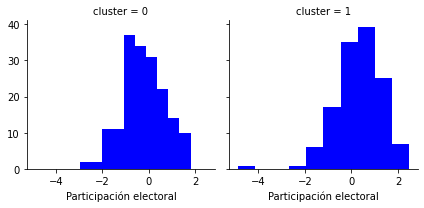

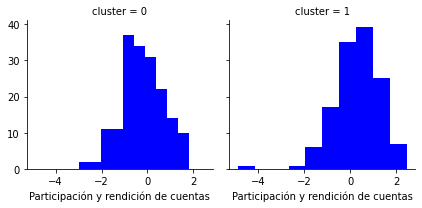

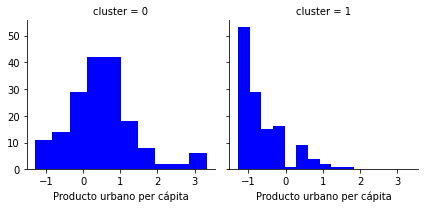

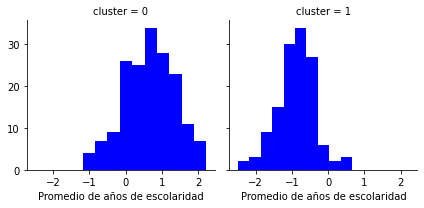

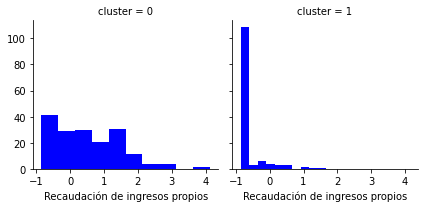

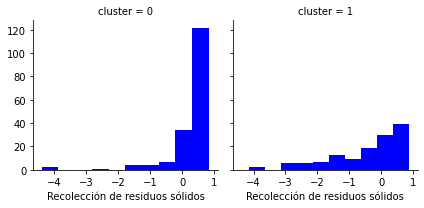

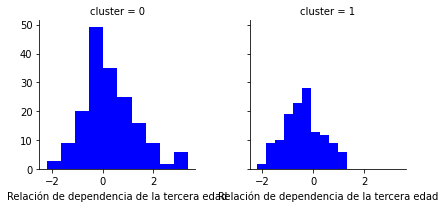

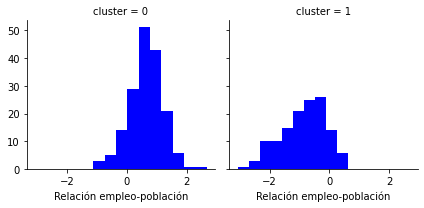

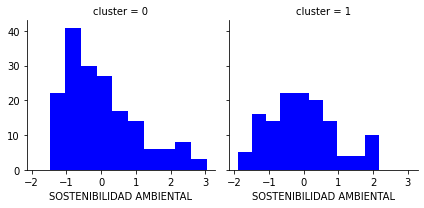

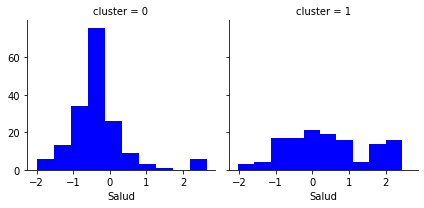

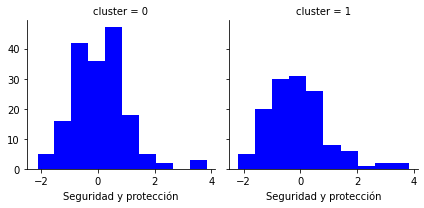

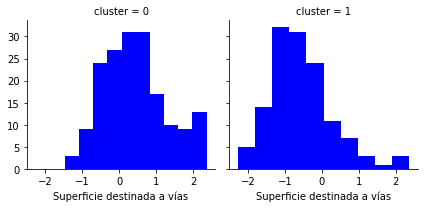

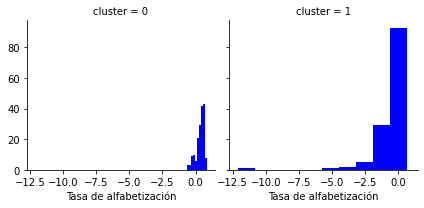

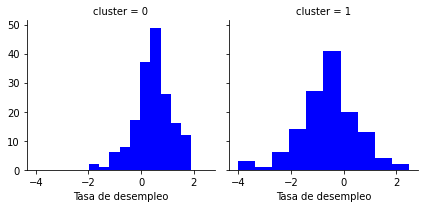

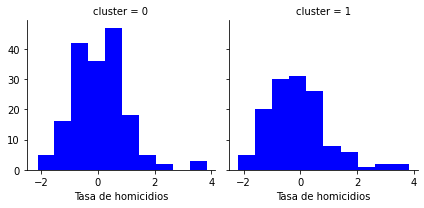

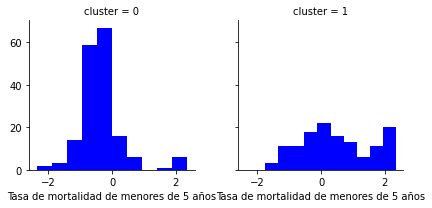

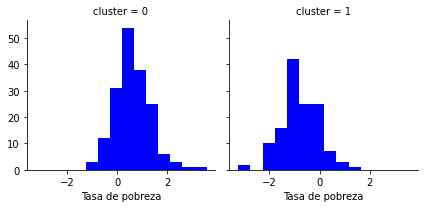

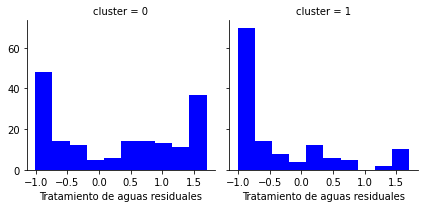

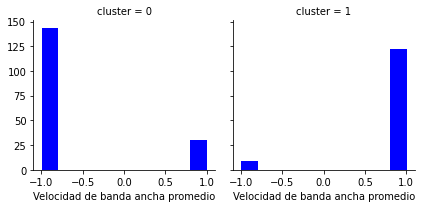

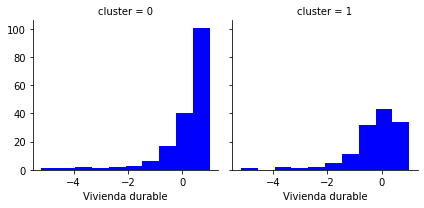

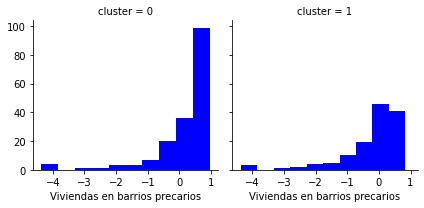

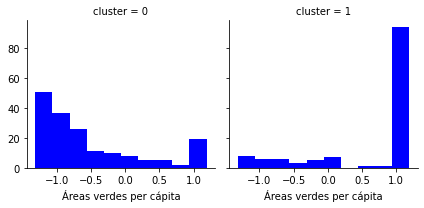

In [107]:
data2= ds_cpi_reduce.drop(columns = ['Energía', 'Proporción de generación de energía renovable'])
data2['cluster'] = ds_cpi_reduced['cluster']
aux = data2.columns.tolist()


for cluster in aux[0:len(aux)-1]:
  grid = sns.FacetGrid(data2,col="cluster");
  grid.map(plt.hist, cluster, color= 'blue');
  

###Promedio por Cluster en cada una de las variables

In [108]:
data2.groupby('cluster').mean()

,Accesibilidad al espacio público abierto,Acceso a Internet,Acceso a agua mejorada,Aglomeración económica,CALIDAD DE VIDA,Calidad del aire,Capacidad institucional y ﬁnanzas municipales,Coeﬁciente de Gini,Concentraciones de material particulado,Concentración de CO2,Crecimiento económico,Densidad de la interconexión vial,Densidad de médicos,Densidad económica,Densidad poblacional,Densidad vial,Desempleo juvenil,Deuda subnacional,EQUIDAD E INCLUSIÓN SOCIAL,Educación,Empleo,Equidad económica,Espacio habitable suﬁciente,Espacio público,Esperanza de vida al nacer,Eﬁciencia del gasto local,Eﬁciencia en el uso de suelo,Fatalidades de tránsito,Forma urbana,GOBERNANZA Y LEGISLACIÓN URBANA,Gobernanza de la urbanización,INFRAESTRUCTURA DE DESARROLLO,Inclusión de género,Inclusión social,Infraestructura de comunicaciones,Infraestructura de vivienda,Infraestructura social,Inscripción equitativa en educación a nivel secundario,Longitud de transporte masivo,Manejo de residuos,Movilidad urbana,Número de estaciones de monitoreo,PRODUCTIVIDAD,Participación electoral,Participación y rendición de cuentas,Producto urbano per cápita,Promedio de años de escolaridad,Recaudación de ingresos propios,Recolección de residuos sólidos,Relación de dependencia de la tercera edad,Relación empleo-población,SOSTENIBILIDAD AMBIENTAL,Salud,Seguridad y protección,Superﬁcie destinada a vías,Tasa de alfabetización,Tasa de desempleo,Tasa de homicidios,Tasa de mortalidad de menores de 5 años,Tasa de pobreza,Tratamiento de aguas residuales,Velocidad de banda ancha promedio,Vivienda durable,Viviendas en barrios precarios,Áreas verdes per cápita
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.258747,0.291271,0.245099,0.502396,-0.098167,0.309487,0.525057,-0.010899,0.397562,1.0,0.57378,0.130601,0.375419,0.502396,0.416885,0.237901,-0.022466,0.318721,0.259729,0.651806,0.616095,0.469390,0.0,-0.386856,0.029679,0.251013,-0.283337,0.035529,0.309018,-0.081308,-0.283337,0.274600,-0.052021,0.143166,0.042646,0.436833,0.375419,-0.052021,0.063812,0.219240,-0.203817,-0.043448,0.662025,-0.213810,-0.213810,0.508353,0.664670,0.494780,0.328957,0.298578,0.655350,0.022661,-0.328490,0.073232,0.426437,0.327480,0.438966,0.073232,-0.355950,0.591603,0.286837,-0.651897,0.205966,0.166020,-0.526124
1,-0.343679,-0.386879,-0.325551,-0.667305,0.130390,-0.411074,-0.697403,0.014477,-0.528059,1.0,-0.76212,-0.173470,-0.498648,-0.667305,-0.553725,-0.315991,0.029840,-0.423339,-0.344983,-0.865758,-0.818325,-0.623464,0.0,0.513840,-0.039421,-0.333407,0.376340,-0.047192,-0.410452,0.107997,0.376340,-0.364736,0.069096,-0.190160,-0.056644,-0.580221,-0.498648,0.069096,-0.084757,-0.291205,0.270719,0.057709,-0.879330,0.283992,0.283992,-0.675217,-0.882843,-0.657189,-0.436935,-0.396584,-0.870465,-0.030099,0.436314,-0.097270,-0.566412,-0.434974,-0.583054,-0.097270,0.472788,-0.785793,-0.380989,0.865879,-0.273573,-0.220515,0.698822


In [109]:
data2

Accesibilidad al espacio público abierto  ...  cluster
Entidad Federativa municipio                                                            ...         
Aguascalientes     Aguascalientes                                             0.512627  ...        0
                   Jesús María                                               -1.199382  ...        0
                   San Francisco de los Romo                                  1.817387  ...        0
Baja California    Ensenada                                                  -1.651067  ...        0
                   Mexicali                                                  -0.970854  ...        0
...                                                                                ...  ...      ...
Yucatán            Progreso                                                  -0.972318  ...        0
                   Umán                                                       0.666932  ...        0
Zacatecas          Fresnillo                                                 -0.370723  ...        1
                   Guadalupe                                                  0.680117  ...        0
                   Zacatecas                                                 -0.273061  ...        0

[305 rows x 66 columns]

In [114]:
data2.reset_index().to_csv("Clusterizado.csv")